In [1]:
from Data.IMDB import IMDB
from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
import dgl
import torch    

/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /storage/scratch/0994359/hetero-conv-matching/.venv/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/torch

In [2]:
imdb = IMDB()
original_graph = imdb.load_graph(50)


In [3]:
device = "cuda:1"
original_graph = original_graph.to(device)
num_nearest_init_neighbors_per_type = {"actortomovie": 50, "directortomovie": 50, "movietoactor":50, "movietodirector":50, "actor":50, "director":50, "movie":50}
from Projections.CCA import CCA
from Projections.JLRandom import JLRandomProjection
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type, checkpoints=[0.99], folder_name="imdb_test" ,device=device,cca_cls=CCA, use_zscore=False, pairs_per_level=20,norm_p=1, approx_neigh=True, add_feat=False, use_out_degree=False) 

coarsener.init()

/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


actortomovie
directortomovie
movietoactor
movietodirector


In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
#coarsener.r = 0.1


coarsener.summarize()

step: 0, ratio: 1.0


/storage/scratch/0994359/hetero-conv-matching/Coarsener/HeteroCoarsener.py:395: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:39.)
  indices = torch.searchsorted(sorted_mapping[:, 0], query_nodes)


step: 1, ratio: 0.9990530303030303
step: 2, ratio: 0.9981060606060606
step: 3, ratio: 0.9971590909090909
step: 4, ratio: 0.9962121212121212
step: 5, ratio: 0.9952651515151515
step: 6, ratio: 0.9943181818181818
step: 7, ratio: 0.9933712121212122
step: 8, ratio: 0.9924242424242424
step: 9, ratio: 0.9914772727272727
step: 10, ratio: 0.990530303030303


In [5]:
import torch
coarsend_graph = coarsener.summarized_graph

#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("movie")
coarsener.make_mask(mapping, "movie")

labels = coarsener.get_labels(mapping, "movie")
coarsend_graph.nodes["movie"].data["label"] = torch.tensor([labels[i] for i in range(len(labels)) ],  device=device) #,
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


ratio 0.9895833333333334


In [6]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
import importlib
from Experiments.model_helper import run_experiments
from Experiments.plots import plot_bar, plot_line
orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,  ImprovedGCN, num_runs=1, epochs=600,eval_interval=1, target_node_type="movie")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]


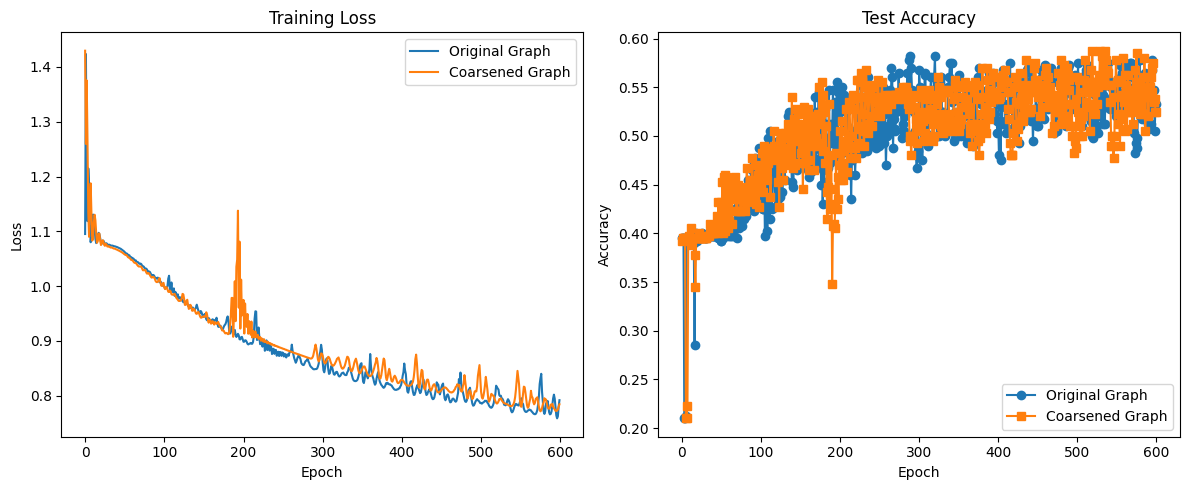

Final Performance Comparison:
Original Graph Accuracy: 0.5325
Coarsened Graph Accuracy: 0.5250

Original Graph Accuracy:
  Mean: 0.5325
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.5250
  Std:  0.0000


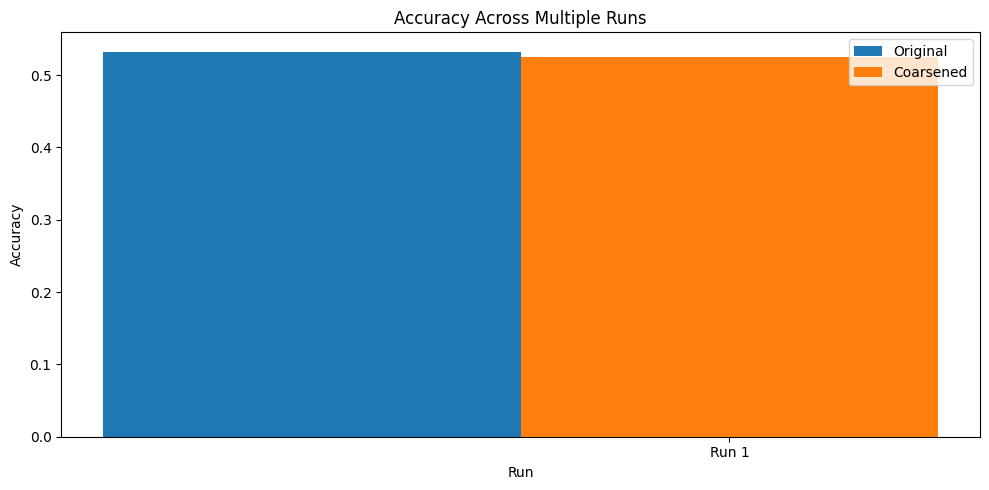

In [ ]:
from Experiments.plots import plot_bar, plot_line

epochs = list(range(600))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)

TypeError: can't convert cuda:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

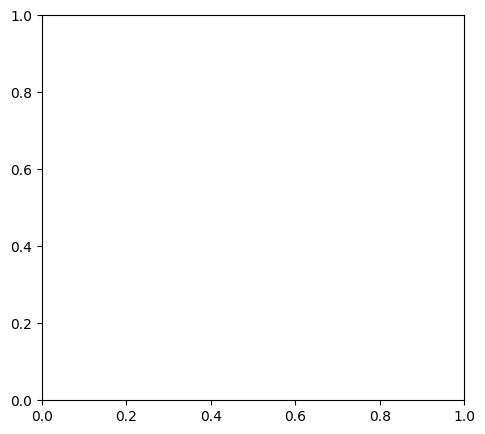

In [ ]:
epochs = torch.tensor(epochs, device=device)
